In [2]:
import time
import numpy as np
from numpy import fft
import scipy.io.wavfile
from scipy.signal import get_window
import scipy.fftpack as fft    
import matplotlib.pyplot as plt
import IPython.display as ipd

In [3]:
def add_eps(x):
    x[np.where(x == 0)] = np.finfo(dtype=x.dtype).eps
    return x

def pre_emphasis(sequence, coeffcient):
    return np.append(sequence[0], sequence[1:] - coeffcient * sequence[:-1])

def freq_to_mel(frequency):
    return 1125.0 * np.log(1.0 + frequency / 700.0)

def mel_to_freq(mel):
    return 700.0 * (np.exp(mel / 1125.0) - 1.0)

def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = mel_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

def iter_bin(out, curr_bin, next_bins, backward=False):
    next_bin = next_bins[scipy.where(next_bins > curr_bin)][0]
    if backward:
        sign = -1
        bias = next_bin
    else:
        sign = 1
        bias = curr_bin
    for f in range(int(curr_bin), int(next_bin)):
        out[f] = sign * (f - bias) / (next_bin - curr_bin)

def mel_filterbank(num_bank, num_freq, sample_freq, low_freq, high_freq):
    num_fft = (num_freq - 1) * 2
    low_mel = freq_to_mel(low_freq)
    high_mel = freq_to_mel(high_freq)
    banks = np.linspace(low_mel, high_mel, num_bank + 2)
    bins = np.floor((num_fft + 1) * mel_to_freq(banks) / sample_freq)
    out = np.zeros((num_bank, num_fft // 2 + 1))
    for b in range(num_bank):
        iter_bin(out[b], bins[b], bins[b+1:])
        iter_bin(out[b], bins[b+1], bins[b+2:], backward=True)
    return out


def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis


In [4]:
sample_path = '/home/dell/Downloads/Study/VAIS/Speech/speechSample/activity_unproductive.wav'

# STFT conf
frame_length = 25  # frame/msec # 25 length frame => 1 phone is catched
frame_shift = 10   # frame/msec # this frame shifting will reduce noise 
remove_dc_offset = True
window_type = "hamming"

# Fbank conf
preemphasis_coeff = 0.97
use_power = True  # else use magnitude
high_freq = 0.0  # offset from Nyquist freq [Hz]
low_freq = 20.0  # offset from 0 [Hz]
num_mel_bins = 80  # (default 23)
num_ceps = 13
num_lifter = 22

sample_freq, raw_seq = scipy.io.wavfile.read(sample_path)
print("sample_freq = ", sample_freq, ", raw_seq", raw_seq)

assert raw_seq.ndim == 1  # assume mono
seq = raw_seq.astype(np.float64)
if remove_dc_offset:
    seq -= np.mean(seq)
print("seq = ", seq)

# STFT feat
seq = pre_emphasis(seq, preemphasis_coeff)
num_samples = sample_freq // 1000
window = scipy.signal.get_window(window_type, frame_length * num_samples)
mode = "psd" if use_power else "magnitude"
f, t, spectrogram = scipy.signal.spectrogram(seq, sample_freq, window=window, noverlap=frame_shift*num_samples, mode=mode)

# log-fbank feat
banks = mel_filterbank(num_mel_bins, spectrogram.shape[0], sample_freq, low_freq, sample_freq // 2 - high_freq)
fbank_spect = np.dot(banks, spectrogram)
logfbank_spect = np.log(add_eps(fbank_spect))

# mfcc feat
dct_feat = scipy.fftpack.dct(logfbank_spect, type=2, axis=0, norm="ortho")[:num_ceps]
lifter = 1 + num_lifter / 2.0 * np.sin(np.pi * np.arange(num_ceps) / num_lifter)
mfcc_feat = lifter[:, np.newaxis] * dct_feat


output_path = "/home/dell/Downloads/Study/VAIS/Speech/MFCC/output_MFCC/mathematical/"

out_filename = lambda name: plt.savefig(output_path + name + ".svg")

sample_freq =  22050 , raw_seq [128 128 128 ... 129 129 128]
seq =  [-0.3293886 -0.3293886 -0.3293886 ...  0.6706114  0.6706114 -0.3293886]


/tmp/ipykernel_20568/3365031860.py:36: DeprecationWarning: scipy.where is deprecated and will be removed in SciPy 2.0.0, use numpy.where instead
  next_bin = next_bins[scipy.where(next_bins > curr_bin)][0]


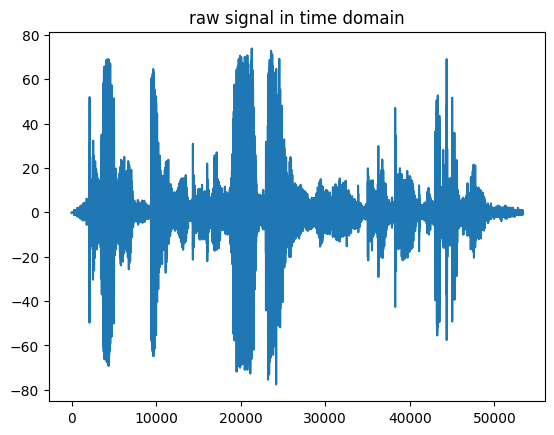

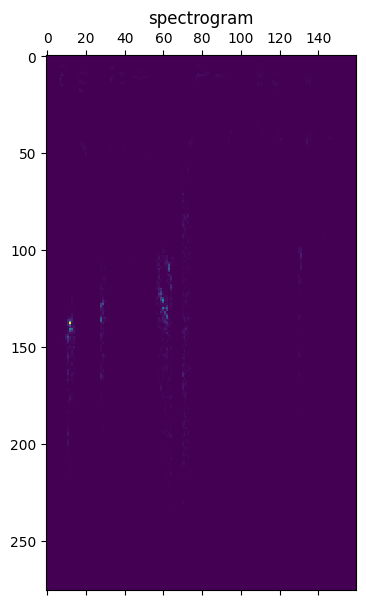

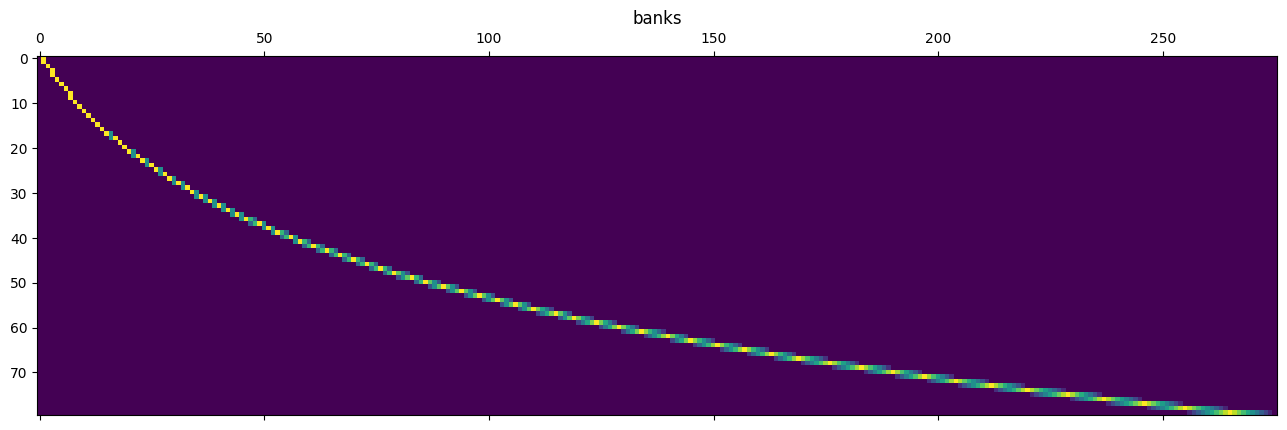

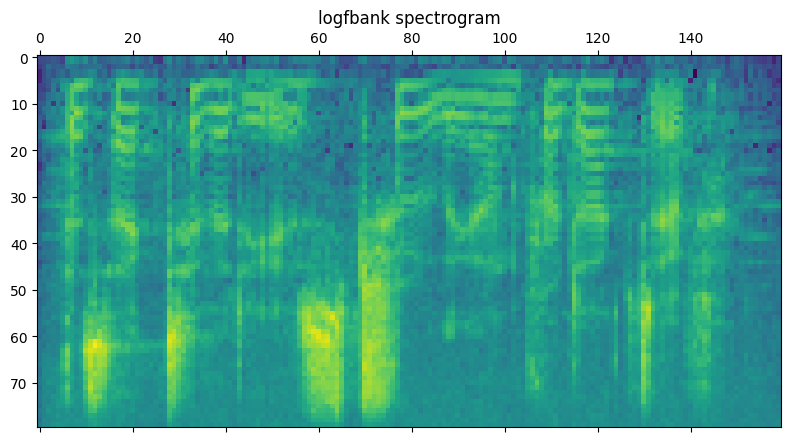

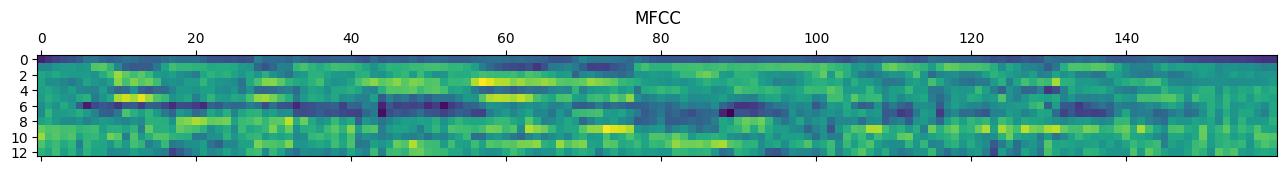

In [ ]:
plt.plot(seq)
out_filename("signal")
plt.matshow(spectrogram)
out_filename("spectrogram")
plt.matshow(banks)
out_filename("banks")
plt.matshow(logfbank_spect)
out_filename("logfbank")
plt.matshow(mfcc_feat)
out_filename("mfcc")
plt.show()


In [13]:
# 1. Frame the signal into short frames.
import numpy as np
from scipy.io import wavfile

sample_audio = "/home/dell/Downloads/Study/VAIS/Speech/speechSample/activity_unproductive.wav"
fs, wavdata = wavfile.read(sample_path) # read a wav file into numpy array
print(fs,wavdata.shape) # print frequency and sample count (sample count = frequency * wav 

frame_len = 25 # each frame length (ms)
frame_shift = 10 # frame shift length (ms)
frame_len_samples = frame_len*fs//1000 # each frame length (samples)
frame_shift_samples = frame_shift*fs//1000 # frame shifte length (samples)
total_frames = int(np.ceil((len(wavdata) - frame_len_samples)/float(frame_shift_samples)) + 1) # total frames will get
padding_length = int((total_frames-1)*frame_shift_samples + frame_len_samples - len(wavdata)) # how many samples last frame need to pad

pad_data = np.pad(wavdata,(0,padding_length),mode='constant') # pad last frame with zeros

""" when we frame the signal, usually we do Pre-emphasis first to amplify high frequency signals.
    Pre-emphasis function:
        y(n) = x(x)-a*x(x-1)  
    The reason why we do Pre-emphasis please watch reference: https://zhuanlan.zhihu.com/p/34798429
    Also, we often add a window function to the frame to reduce signal discontinuity at the beginning and end of the frame.
    There are many window functions, we use hamming window here as an example.
"""
frame_data = np.zeros((total_frames,frame_len_samples)) # where we save the frame results
pre_emphasis_coeff = 0.97 # Pre-emphasis coefficient
window_func = np.hamming(frame_len_samples) # hamming window
pad_data = np.append(pad_data[0],pad_data[1:]-pre_emphasis_coeff*pad_data[:-1]) # Pre-emphasis

for i in range(total_frames):
    single_frame = pad_data[i*frame_shift_samples:i*frame_shift_samples+frame_len_samples] # original frame data
    single_frame = single_frame * window_func # add window function
    frame_data[i,:] = single_frame


K = 512 # length of DFT
freq_domain_data = np.fft.rfft(frame_data,K) # DFT
power_spec = np.absolute(freq_domain_data) ** 2 * (1/K) # power spectrum

low_frequency = 20 # We don't use start from 0 Hz because human ear is not able to perceive low frequency signal.
high_frequency = fs//2 # if the speech is sampled at f Hz then our upper frequency is limited to 2/f Hz.
low_frequency_mel = 2595 * np.log10(1 + low_frequency / 700)
high_frequency_mel = 2595 * np.log10(1 + high_frequency / 700)
n_filt = 40 # number of mel-filters (usually between 22-40)
mel_points = np.linspace(low_frequency_mel, high_frequency_mel, n_filt + 2) # Make the Mel scale spacing equal.
hz_points = (700 * (10**(mel_points / 2595) - 1)) # convert back to Hz scale.
bins = np.floor((K + 1) * hz_points / fs) # round those frequencies to the nearest FFT bin.

fbank = np.zeros((n_filt, int(np.floor(K / 2 + 1))))
for m in range(1, n_filt + 1):
    f_m_minus = int(bins[m - 1])   # left point
    f_m = int(bins[m])             # peak point
    f_m_plus = int(bins[m + 1])    # right point

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
filter_bank = np.matmul(power_spec,fbank.T) # This is known as fbank feature.
filter_bank = np.where(filter_bank == 0,np.finfo(float).eps,filter_bank) # Repalce 0 to a small constant or it will cause problem to log.

log_fbank = np.log(filter_bank) # We can also use log_fbank = 20*np.log10(filter_bank) to get dB e

num_ceps = 12 # MFCC feature dims, usually between 2-13.


from scipy.fftpack import dct
# feature from other dims are dropped beacuse they represent rapid changes in filter bank coefficients and they are not helpful for speech models.
mfcc = dct(log_fbank, type=2, axis=1, norm="ortho")[:, 1 : (num_ceps + 1)] 

22050 (53320,)


In [1]:
import librosa

# MEL FILTER BANK  IN LIBROSA
n_fft = 256 
n_mels = 64
sample_rate = 6000

mel_filters_librosa = librosa.filters.mel (
    sr = sample_rate,
    n_fft = n_fft,
    n_mels = n_mels,
    fmin  = 0.0,
    fmax = sample_rate/2.0,
    norm = "slaney",
    htk = True,
)

plot_fbank(mel_filters_librosa, title = "Mel filter in librosa")

NameError: name 'plot_fbank' is not defined